## Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import torch.optim as optim

from torch.utils.data import random_split, ConcatDataset
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchvision.models import get_model, get_model_weights, get_weight, list_models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.transforms.functional import normalize, to_tensor, resize, to_pil_image

from pathlib import Path
from PIL import ImageEnhance
from PIL import Image

import pandas as pd

from tqdm import tqdm

/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Define Hyperparameters

In [2]:
batch_size = 100
learning_rate = 0.001
epochs = 500

## Load Images into PyTorch Dataset and Apply Transforms

In [3]:
basepath = Path('/home/alexwebber/toorange/alexwebber/mixteclabeling') # Base data directory
path_v = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'
path_n = basepath / 'data/labeled_figures/codex_nuttall/gender/'
path_s = basepath / 'data/labeled_figures/codex_selden/gender/'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((227, 227), antialias=True),
])

vindobonensis_dataset = datasets.ImageFolder(path_v, transform=transform)
nuttall_dataset = datasets.ImageFolder(path_n, transform=transform)
selden_dataset = datasets.ImageFolder(path_s, transform=transform)

figures_dataset = ConcatDataset([vindobonensis_dataset, nuttall_dataset, selden_dataset])

train_set, validation_set, test_set = random_split(figures_dataset, [0.6, 0.2, 0.2])

dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

gender_dict = {0: "male", 1: "female"}

## Load and Display Reference Images

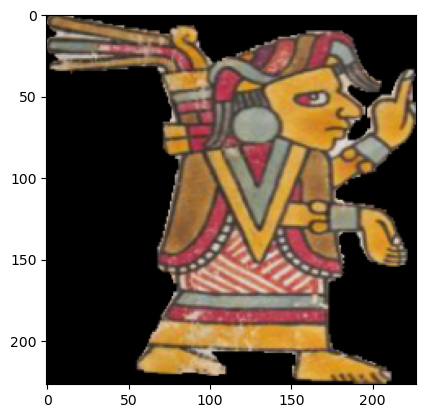

In [4]:
reference_images = ["../data/reference_images/gender/female/003-a-06.png"]

data = [transform(Image.open(ref).convert("RGB")) for ref in reference_images]

data = torch.stack(data)

image = transforms.ToPILImage()(data[0])

plt.imshow(image)

## Define VGG Model and Output Features

In [5]:
class Vgg16(nn.Module):
    def __init__(self):
        super().__init__()
        self.modules_no = [0,2,5,7,10,12,14,17,19,21,24,26,28]
        self.features = vgg16(pretrained=True).features
        self.features[4]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[9]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[16] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[23] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[30] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        
        self.classifier = vgg16(pretrained=True).classifier
        self.classifier[6] = nn.Linear(4096, 2)
                
        
    def forward(self,x):
        results = {}
        maxpool_indices = {}
        for index, layer in enumerate(self.features):
            if index in [4,9,16,23,30]:
                x,i = layer(x)
                maxpool_indices[index] = i
                
            else:
                x = layer(x)
            
            if index in self.modules_no:
                results[index] = x
                
        x = torch.flatten(x, 1)
        x = self.classifier(x)
                
        return x, results, maxpool_indices
    

## Instantiate Model and Define Working Device

In [6]:
model = Vgg16()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Freeze Initial Low-Level Features, then Unfreeze High-Level Feature Layers

In [7]:
for i in range(0, 19):                
    for param in model.features[i].parameters():
        param.requires_grad = False

# Fine tuning last layers
for i in range(19, 30):
    for param in model.features[i].parameters():
        param.requires_grad = True

## Send Model to GPU

In [8]:
model = model.to(device)

## Definte File Path for Model Saves

In [9]:
savepath = "model_saves/base_model.pth"

## Define Loss Function and Optimizer (Weighted for Gender)

In [10]:
gender_balance = torch.tensor([1/386, 1/899])
gender_balance = gender_balance.to(device)

criterion = nn.CrossEntropyLoss(weight=gender_balance)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train Model and Output Activation Maps for Reference Image

In [ ]:
for epoch in tqdm(range(epochs)):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()

        predictions, activations, max_indices = model(inputs)

        # Get the output from the last layer
        outputs = predictions

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()

    data = data.cuda()

    preds, out, maxpool_ind = model(data)
    
    class_probability = torch.nn.functional.softmax(preds, dim=1)
    
    if(class_probability[0][0].item() > class_probability[0][1].item()):
        predicted_class = gender_dict[0]
        prediction_strength = round(class_probability[0][0].item(), 2)
        
    elif(class_probability[0][0].item() < class_probability[0][1].item()):
        predicted_class = gender_dict[1]
        prediction_strength = round(class_probability[0][1].item(), 2)

    ind = 1

    plt.figure(figsize=[20, 50])

    ## Calculating average activation in outputs
    for layer in out:
        mean = torch.zeros(np.shape(out[layer])[2], np.shape(out[layer])[3])
        mean = mean.cuda()
        for i in out[layer][0]:
            mean += i
        vis_mean = transforms.ToPILImage()(mean/np.shape(out[layer])[1])
        plot_loc = plt.subplot(13, 3, ind)

        ind += 1    
        plt.imshow(vis_mean,cmap='magma')
        
        plt.title(f'Epoch: {epoch + 1} | {reference_images[0][-12:-4]} | Layer: {layer} | {predicted_class}/{prediction_strength}')
        plt.colorbar()

    plt.savefig(f'cam_output/gender/003-a-06/{epoch:05d}.png')

    plt.close()
    
    model.train()

 19%|█▉        | 95/500 [06:15<24:30,  3.63s/it] 

## Generate Video of Class Activation Maps

In [ ]:
ffmpeg -framerate 30 -pattern_type glob -i 'cam_output/gender/003-a-06/*.png' -c:v libx264 -pix_fmt yuv420p videos/demo.mp4

## Display Video

<video controls src="videos/demo.mp4" />

## Save Trained Model for Testing

In [ ]:
model.eval()

savepath = "model_saves/trained_model.pth"
torch.save(model.state_dict(), savepath)

# Testing

## Load images and labels from test_loader

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

## Load model

In [ ]:
model = Vgg16()
model.load_state_dict(torch.load(savepath))
model.to(device)

## Calculate Performance of Model (Accuracy, Precision, Recall, & F1)

In [ ]:
metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")